In [3]:
import re
import glob
from pathlib import Path

import numpy as np
import pandas as pd


In [15]:
# quick test
filepath="/disk/bifrost/yuanze/KBSS/skirtor_2016-7-18"
parse_params_from_filename(filepath+"/"+"t3_p0_q0_oa10_R10_Mcl0.97_i0_sed.dat")


[('t', 3.0),
 ('p', 0.0),
 ('q', 0.0),
 ('oa', 10.0),
 ('R', 10.0),
 ('Mcl', 0.97),
 ('i', 0.0)]

In [57]:
_token_re = re.compile(r'^([A-Za-z]+)([+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)$')

def parse_params_from_filename(fname: str):
    base = Path(fname).name
    base = base.replace("_sed.dat", "").replace(".dat", "")
    parts = base.split("_")
    kv = []
    for part in parts:
        m = _token_re.match(part)
        if m:
            k, v = m.group(1), float(m.group(2))
            kv.append((k, v))
    return kv

def wave_um_to_AA(w_um):
    return np.asarray(w_um, float) * 1e4  # 1 micron = 1e4 Angstrom

def interp1d_linear(x, xp, fp):
    """Scalar x, 1D xp, fp can be (..., n) with interpolation along last axis."""
    xp = np.asarray(xp, float)
    x = float(np.clip(x, xp[0], xp[-1]))
    j = np.searchsorted(xp, x)
    if j == 0:
        return fp[..., 0]
    if j >= xp.size:
        return fp[..., -1]
    x0, x1 = xp[j-1], xp[j]
    w = (x - x0) / (x1 - x0)
    return fp[..., j-1] * (1.0 - w) + fp[..., j] * w

def build_sed_npz_from_lamLlam(
    folder=".",
    pattern="*_sed.dat",
    out_npz="sed_L5100norm.npz",
    param_order=("t","p","q","oa","R","i"),   # exclude Mcl if you want
    lambda0_AA=5100.0,
    float_dtype=np.float32,
    wave_tol=1e-8,
    store_y5100=True,  # store original (lambda L_lambda)(5100) per grid point (in input units)
):
    paths = sorted(glob.glob(str(Path(folder) / pattern)))
    if not paths:
        raise FileNotFoundError(f"No files found with pattern={pattern} in {folder}")

    # Collect parameter table
    records = []
    for p in paths:
        kv = dict(parse_params_from_filename(p))
        rec = {"file": p}
        for k in param_order:
            if k not in kv:
                raise ValueError(f"File {p} missing parameter '{k}' (parsed keys={list(kv.keys())})")
            rec[k] = float(kv[k])
        records.append(rec)
    df = pd.DataFrame(records)

    # Parameter grids
    grids = {k: np.sort(df[k].unique().astype(float)) for k in param_order}
    shapes = [len(grids[k]) for k in param_order]

    # Load reference wavelength grid
    w_um0, y0 = np.loadtxt(paths[0], unpack=True, usecols=(0,1))
    wave_AA = wave_um_to_AA(w_um0).astype(float_dtype)
    n_wave = wave_AA.size

    # Allocate SED cube: log10(L_lambda_norm) with last axis wavelength
    sed = np.full(shapes + [n_wave], np.nan, dtype=float_dtype)
    y5100_grid = np.full(shapes, np.nan, dtype=float_dtype) if store_y5100 else None

    for p in paths:
        kv = dict(parse_params_from_filename(p))

        # index in each param axis
        idx = []
        for k in param_order:
            val = float(kv[k])
            grid = grids[k]
            j = np.searchsorted(grid, val)
            if j >= len(grid) or not np.isclose(grid[j], val, atol=1e-12, rtol=0):
                raise ValueError(f"Value {val} for {k} not found in grid for file {p}")
            idx.append(j)

        w_um, y = np.loadtxt(p, unpack=True, usecols=(0,1))  # y = lambda L_lambda
        w_um = np.asarray(w_um, float)
        y = np.asarray(y, float)

        # wave consistency
        if w_um.size != w_um0.size or not np.allclose(w_um, w_um0, atol=wave_tol, rtol=0):
            raise ValueError(f"Wavelength grid mismatch in file {p}. Need a common wave grid.")

        # interpolate y at 5100Å (need x in Å)
        y5100 = float(interp1d_linear(lambda0_AA, wave_AA.astype(float), y))
        y5100 = max(y5100, 1e-300)

        # normalize (lambda L_lambda) so y(5100)=1
        y_norm = y / y5100

        # convert to L_lambda_norm: Lλ = (λLλ)/λ
        Llam_norm = y_norm / np.maximum(wave_AA.astype(float), 1e-300)

        # store log10(L_lambda_norm)
        Llam_norm = np.maximum(Llam_norm, 1e-300)
        sed_log = np.log10(Llam_norm).astype(float_dtype)

        sed[tuple(idx) + (slice(None),)] = sed_log
        if store_y5100:
            y5100_grid[tuple(idx)] = y5100

    # Warn if any missing
    n_missing = np.isnan(sed).sum()
    if n_missing > 0:
        print(f"WARNING: sed grid has {n_missing} NaNs (missing grid points).")

    # Save NPZ
    out = {"sed": sed, "wave": wave_AA}
    for k in param_order:
        out[k] = grids[k].astype(float_dtype)

    # Optional metadata
    out["__normalized__"] = np.array([f"lamLlam@{lambda0_AA}A=1"], dtype=object)
    if store_y5100:
        out["lamLlam_5100_input_units"] = y5100_grid.astype(float_dtype)

    np.savez_compressed(out_npz, **out)
    print("Saved:", out_npz)
    print("Param sizes:", {k: len(grids[k]) for k in param_order}, "Nwave:", n_wave)
    return df, grids, wave_AA, sed


# Run it
df, grids, wave_AA, sed = build_sed_npz_from_lamLlam(
    folder=filepath, 
    pattern="*_sed.dat",
    out_npz=templatepath+"/my_sed_table.npz",
    param_order=["t","p","q","oa","R","i"],  # adjust if needed
    lambda0_AA=5100.0,
    store_y5100=False,
)
df.head()


Saved: /disk/bifrost/yuanze/software/templates/my_sed_table.npz
Param sizes: {'t': 5, 'p': 4, 'q': 4, 'oa': 8, 'R': 3, 'i': 10} Nwave: 132


,file,t,p,q,oa,R,i
0,/disk/bifrost/yuanze/KBSS/skirtor_2016-7-18/t1...,11.0,0.5,0.5,10.0,10.0,0.0
1,/disk/bifrost/yuanze/KBSS/skirtor_2016-7-18/t1...,11.0,0.5,0.5,10.0,10.0,10.0
2,/disk/bifrost/yuanze/KBSS/skirtor_2016-7-18/t1...,11.0,0.5,0.5,10.0,10.0,20.0
3,/disk/bifrost/yuanze/KBSS/skirtor_2016-7-18/t1...,11.0,0.5,0.5,10.0,10.0,30.0
4,/disk/bifrost/yuanze/KBSS/skirtor_2016-7-18/t1...,11.0,0.5,0.5,10.0,10.0,40.0


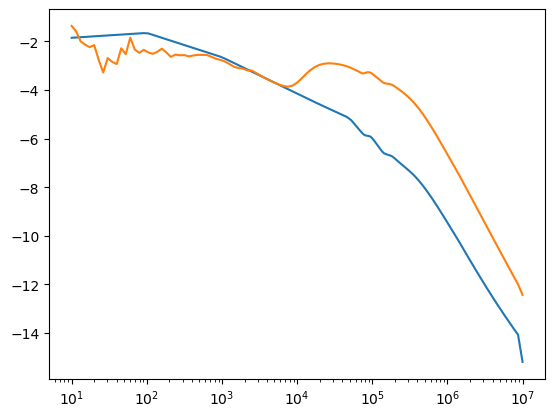

In [66]:
from matplotlib import pyplot as plt
plt.plot(wave_AA,sed[0,0,0,0,0,0,:])
plt.plot(wave_AA,sed[1,3,1,3,1,5,:])

plt.xscale("log")
#plt.yscale("symlog")

In [53]:
import jax.numpy as jnp
from jax.scipy.interpolate import RegularGridInterpolator

# Minimal smoke test (mimics your TableModel logic)
templatepath="/disk/bifrost/yuanze/software/templates"
sed_data = jnp.load(templatepath+"/my_sed_table.npz")

param_names = ["t","p","q","oa","R","i"]  # must match saved keys
points = tuple(sed_data[name] for name in param_names) + (sed_data["wave"],)
intp = RegularGridInterpolator(points, sed_data["sed"], bounds_error=False, fill_value=0.)

# example query point (use valid grid values or interpolate between them)
pardict = {name: float(sed_data[name][1]) for name in param_names}
x = sed_data["wave"]  # some wavelengths

ylog = intp(tuple(pardict[name] for name in param_names) + (x,))
y = 10**(ylog - 38)  # matches your TableModel behavior when norm=False
y.shape, y[:5]


((40,), Array([0., 0., 0., 0., 0.], dtype=float32))

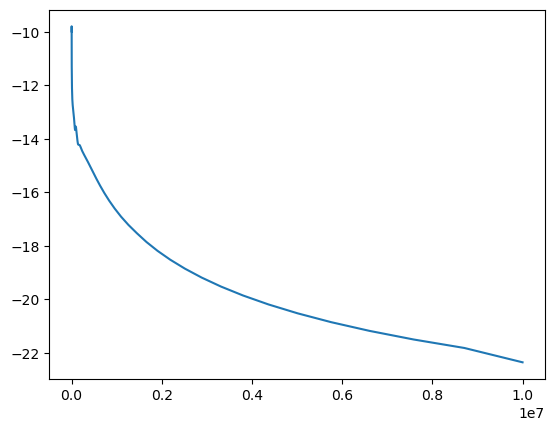

In [55]:
x = sed_data["wave"]  # some wavelengths

ylog = intp(tuple(pardict[name] for name in param_names) + (x,))
plt.plot(x,ylog)
#y = 10**(ylog - 38)  # matches your TableModel behavior when norm=False
#y.shape, y[:5]

In [ ]:
# Cell 5 — how to reload the saved npz later
npz = np.load("spectra_grid.npz", allow_pickle=True)

stacked = bool(npz["stacked"])
table = pd.DataFrame(npz["table"].item())  # stored as dict-of-lists

print("stacked =", stacked)
display(table.head())

if stacked:
    flux = npz["flux"]                  # (n_models, npts)
    wave = npz["wave"]
    if wave.size == 0:
        wave = None
else:
    flux = list(npz["flux"])            # list of 1D arrays (variable length)
    wave = list(npz["wave"])            # list of arrays or None


In [6]:
filepath="/disk/bifrost/yuanze/cigale-v2022.1/pcigale/data/skirtor2016"

In [13]:
pickle.load(filepath+"/Mcl=0.97_R=10_i=0_oa=10_pl=0.0_q=0.0_t=11.pickle")

TypeError: file must have 'read' and 'readline' attributes

In [14]:
load_pickle_any(filepath+"/Mcl=0.97_R=10_i=0_oa=10_pl=0.0_q=0.0_t=11.pickle")

ModuleNotFoundError: No module named 'pcigale'